In [7]:
# Реализуйте высокочастотную фильтрацию на основе ядра Гаусса
# Реализуйте удаление периодического шума

АНАЛИЗ И ФИЛЬТРАЦИЯ ИЗОБРАЖЕНИЯ С ПЕРИОДИЧЕСКИМ ШУМОМ

1. Загрузка и анализ исходного изображения...
   Размер изображения: (594, 787)
   Диапазон значений: [0, 255]

2. Визуализация исходного изображения и его спектра...


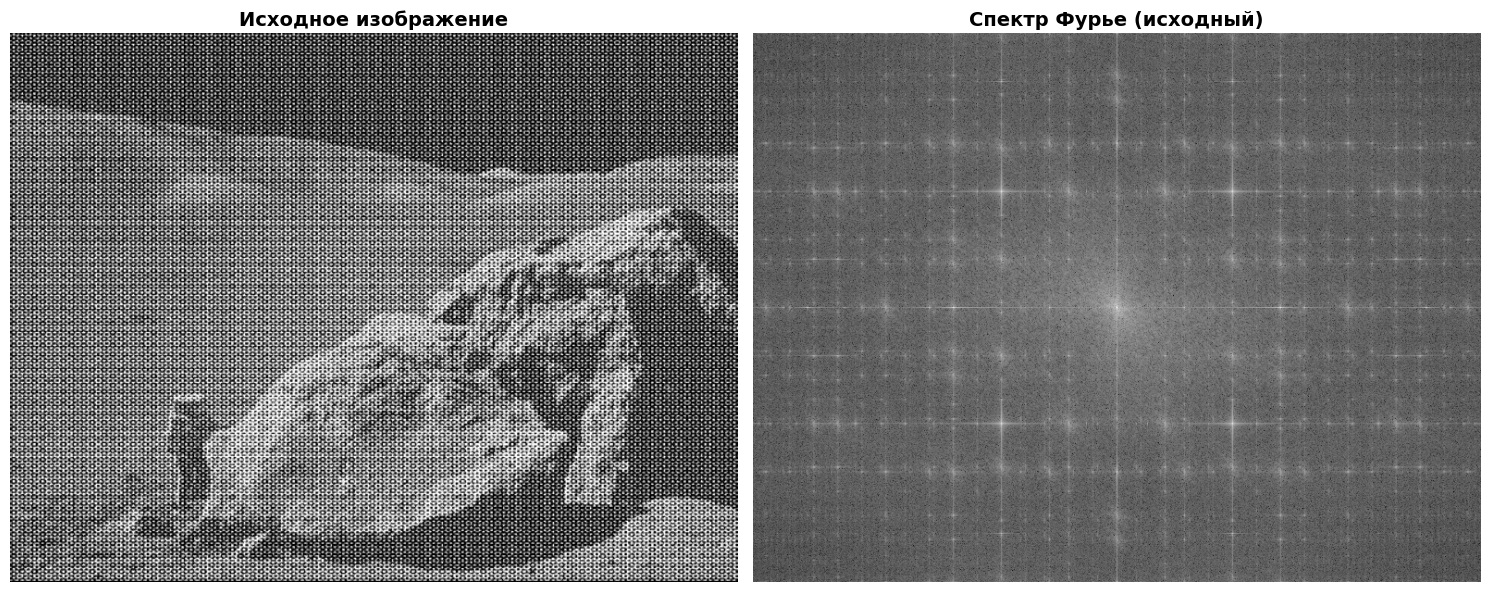


3. Применение высокочастотного фильтра Гаусса...


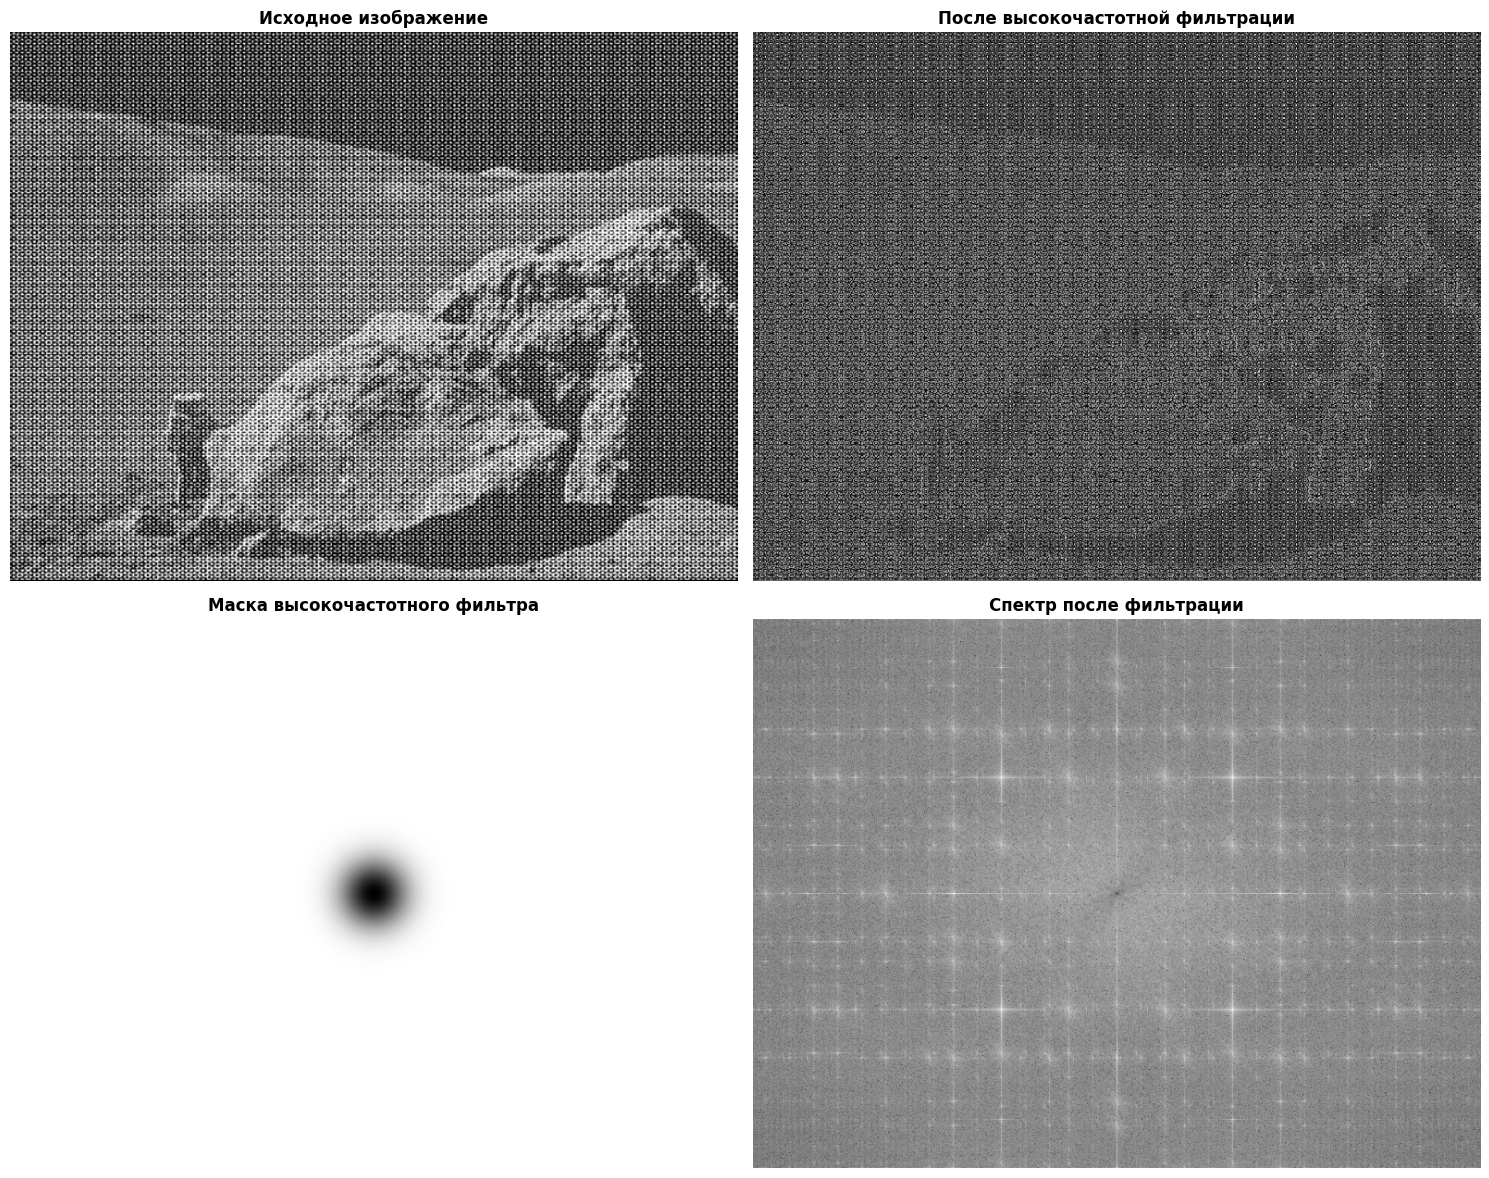


4. Удаление периодического шума...
   Обнаружено точек шума: 17


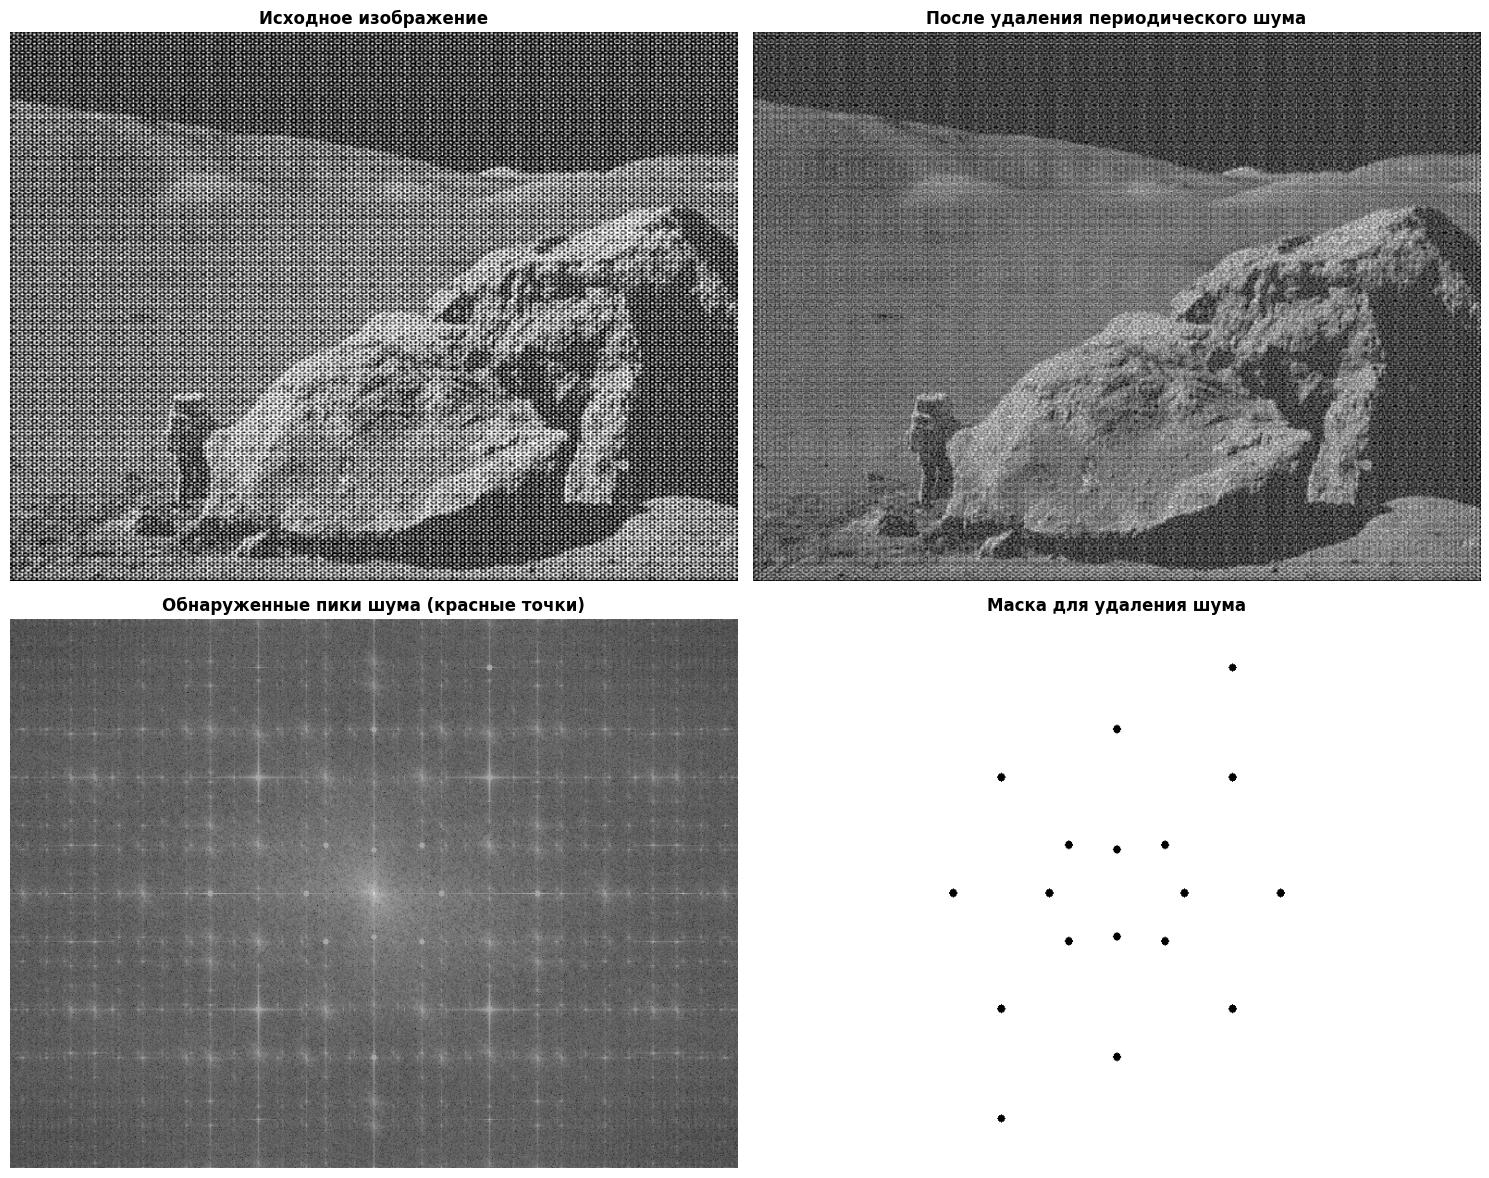


5. Сравнение спектров до и после обработки...


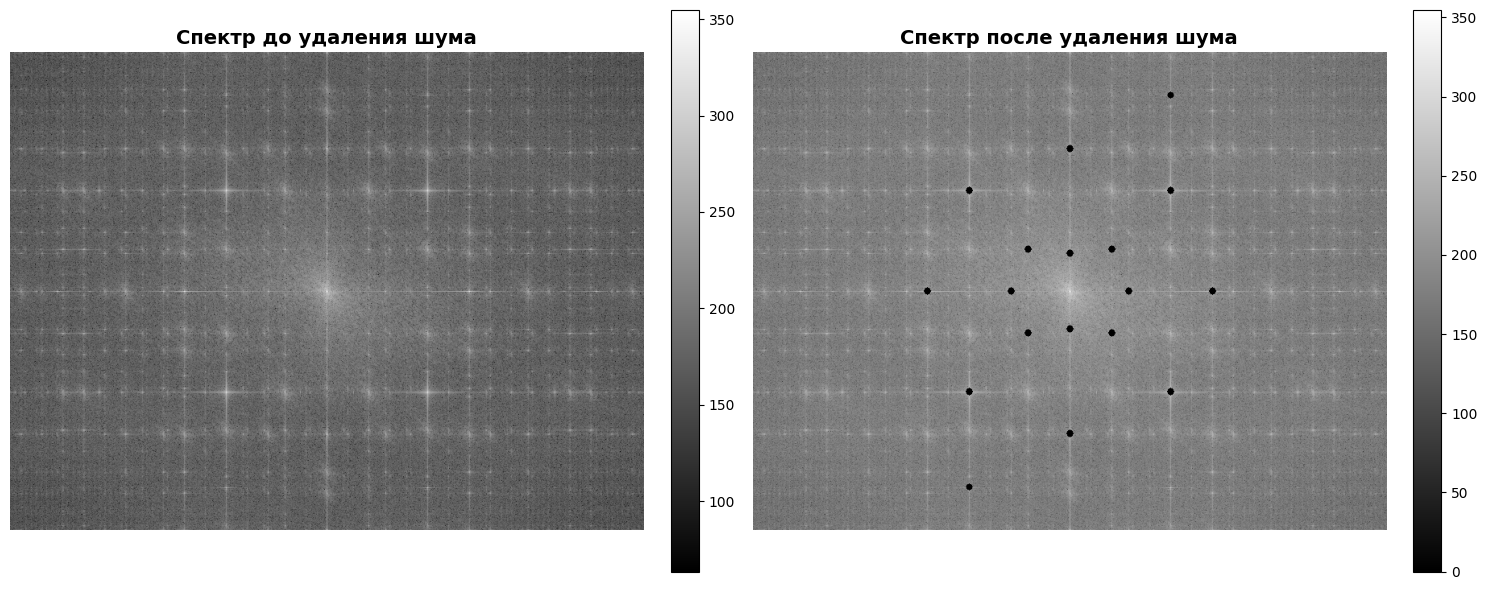


6. Финальное сравнение всех методов...


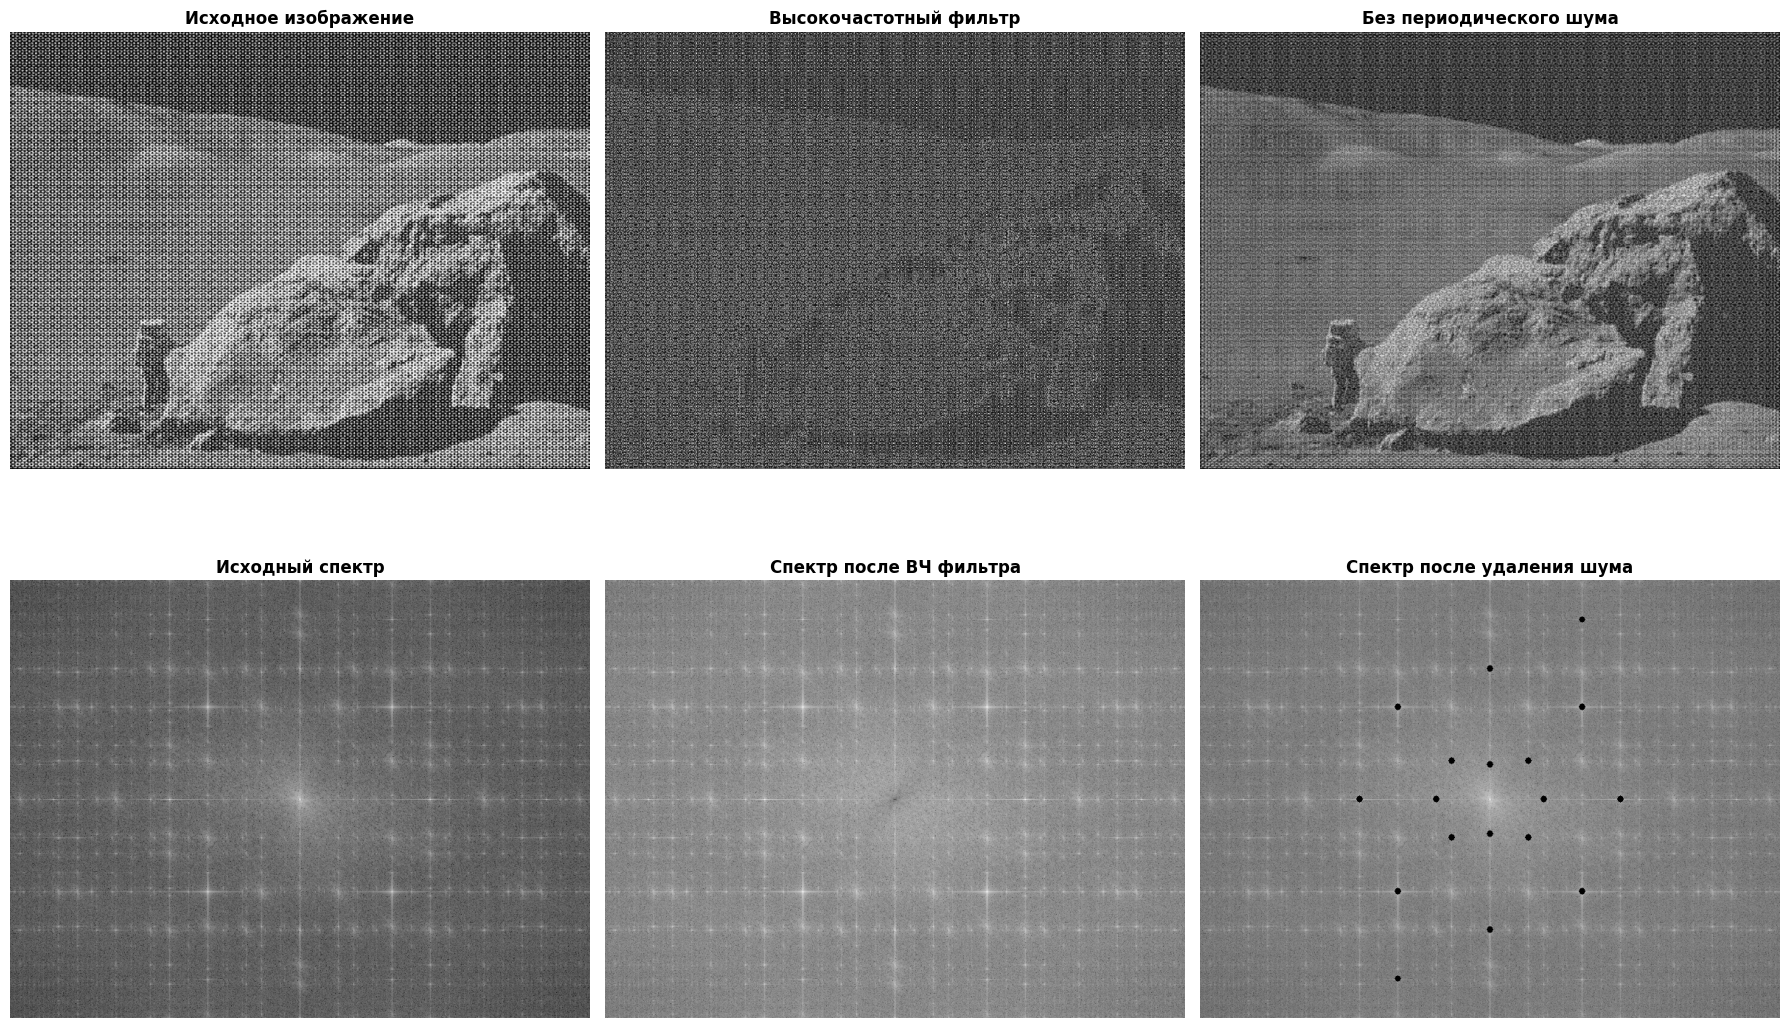

Статистика
Дисперсия исходного изображения: 5614.39
Дисперсия после ВЧ фильтра: 289228924756026.94
Дисперсия после удаления шума: 401345932639491.62

Обнаружено и удалено точек шума: 17


In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
import matplotlib

# Настройка стиля графиков
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 10

def gaussian_high_pass_filter(img, sigma=30):
    """Высокочастотная фильтрация на основе ядра Гаусса"""
    # Прямое преобразование Фурье
    dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    # Создание гауссова высокочастотного фильтра
    rows, cols = img.shape
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    center_x, center_y = cols // 2, rows // 2
    
    # Гауссов низкочастотный фильтр
    gauss_low_pass = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))
    
    # Высокочастотный фильтр
    gauss_high_pass = 1 - gauss_low_pass
    
    # Применение фильтра
    mask = gauss_high_pass[:, :, np.newaxis]
    filtered_dft = dft_shift * mask
    
    # Обратное преобразование Фурье
    f_ishift = np.fft.ifftshift(filtered_dft)
    img_back = cv.idft(f_ishift)
    img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])
    
    # Спектр после фильтрации
    filtered_spectrum = 20 * np.log(cv.magnitude(filtered_dft[:,:,0], filtered_dft[:,:,1]) + 1)
    
    return img_back, gauss_high_pass, filtered_spectrum

def improved_periodic_noise_removal(img, min_distance=25, threshold_rel=0.2, notch_radius=5):
    """удаление периодического шума"""
    # Прямое преобразование Фурье
    dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    # Расчет спектра амплитуд
    magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]) + 1e-6)
    
    # Автоматическое обнаружение пиков шума
    coordinates = peak_local_max(magnitude_spectrum, 
                                min_distance=min_distance, 
                                threshold_rel=threshold_rel,
                                exclude_border=30,
                                num_peaks=20)
    
    rows, cols = img.shape
    center = (cols // 2, rows // 2)
    mask = np.ones_like(dft_shift)
    
    # Визуализация обнаруженных пиков
    spectrum_with_peaks = magnitude_spectrum.copy()
    
    # Создание маски с отверстиями вокруг пиков шума
    noise_points = []
    for y, x in coordinates:
        distance_from_center = np.sqrt((x - center[0])**2 + (y - center[1])**2)
        # Игнорируем центральную область и очень близкие к центру точки
        if distance_from_center > 15 and distance_from_center < min(rows, cols) // 2 - 10:
            # Отмечаем пики на спектре
            cv.circle(spectrum_with_peaks, (x, y), 3, 255, -1)
            
            # Создаем отверстия в маске
            cv.circle(mask, (x, y), notch_radius, (0, 0), -1)
            # Симметричная точка (из-за симметрии Фурье)
            cv.circle(mask, (cols - x - 1, rows - y - 1), notch_radius, (0, 0), -1)
            
            noise_points.append((x, y))
    
    # Применение маски
    filtered_dft = dft_shift * mask
    
    # Спектр после фильтрации
    filtered_spectrum = 20 * np.log(cv.magnitude(filtered_dft[:,:,0], filtered_dft[:,:,1]) + 1)
    
    # Обратное преобразование Фурье
    f_ishift = np.fft.ifftshift(filtered_dft)
    img_back = cv.idft(f_ishift)
    img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])
    
    return img_back, mask[:,:,0], magnitude_spectrum, filtered_spectrum, spectrum_with_peaks, noise_points

def plot_comparison(original, processed, title1, title2, cmap='gray'):
    """Функция для сравнения двух изображений"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.imshow(original, cmap=cmap)
    ax1.set_title(title1, fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    ax2.imshow(processed, cmap=cmap)
    ax2.set_title(title2, fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# Основная программа
def main():

    # Загрузка изображения
    print("\n1. Загрузка и анализ исходного изображения...")
    img = cv.imread('periodic_noise.jpg', cv.IMREAD_GRAYSCALE)
    
    if img is None:
        print("Ошибка: Не удалось загрузить изображение 'periodic_noise.jpg'")
        return
    
    print(f"   Размер изображения: {img.shape}")
    print(f"   Диапазон значений: [{img.min()}, {img.max()}]")
    
    # Анализ исходного спектра Фурье
    dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    original_spectrum = 20 * np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]) + 1)
    
    # Визуализация исходных данных
    print("\n2. Визуализация исходного изображения и его спектра...")
    plot_comparison(img, original_spectrum, 
                   'Исходное изображение', 
                   'Спектр Фурье (исходный)')
    
    # 1. Высокочастотная фильтрация Гаусса
    print("\n3. Применение высокочастотного фильтра Гаусса...")
    high_pass_result, gauss_mask, high_pass_spectrum = gaussian_high_pass_filter(img, sigma=25)
    
    # Визуализация результатов высокочастотной фильтрации
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Исходное изображение', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    ax2.imshow(high_pass_result, cmap='gray')
    ax2.set_title('После высокочастотной фильтрации', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    ax3.imshow(gauss_mask, cmap='gray')
    ax3.set_title('Маска высокочастотного фильтра', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    ax4.imshow(high_pass_spectrum, cmap='gray')
    ax4.set_title('Спектр после фильтрации', fontsize=12, fontweight='bold')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Удаление периодического шума
    print("\n4. Удаление периодического шума...")
    denoised_img, noise_mask, orig_spectrum, filt_spectrum, peaks_spectrum, noise_points = improved_periodic_noise_removal(
        img, min_distance=30, threshold_rel=0.15, notch_radius=4)
    
    print(f"   Обнаружено точек шума: {len(noise_points)}")
    
    # Визуализация результатов удаления шума
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Исходное изображение', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    ax2.imshow(denoised_img, cmap='gray')
    ax2.set_title('После удаления периодического шума', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    ax3.imshow(peaks_spectrum, cmap='gray')
    ax3.set_title('Обнаруженные пики шума (красные точки)', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    ax4.imshow(noise_mask, cmap='gray')
    ax4.set_title('Маска для удаления шума', fontsize=12, fontweight='bold')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Сравнение спектров до и после удаления шума
    print("\n5. Сравнение спектров до и после обработки...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    im1 = ax1.imshow(orig_spectrum, cmap='gray')
    ax1.set_title('Спектр до удаления шума', fontsize=14, fontweight='bold')
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    im2 = ax2.imshow(filt_spectrum, cmap='gray')
    ax2.set_title('Спектр после удаления шума', fontsize=14, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Финальное сравнение всех результатов
    print("\n6. Финальное сравнение всех методов...")
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    images = [img, high_pass_result, denoised_img, 
              original_spectrum, high_pass_spectrum, filt_spectrum]
    titles = ['Исходное изображение', 
              'Высокочастотный фильтр', 
              'Без периодического шума',
              'Исходный спектр', 
              'Спектр после ВЧ фильтра', 
              'Спектр после удаления шума']
    
    for i, (ax, img_data, title) in enumerate(zip(axes.flat, images, titles)):
        ax.imshow(img_data, cmap='gray')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Статистика улучшения
    print("Статистика")
    
    # Расчет метрик качества (упрощенные)
    original_var = np.var(img.astype(float))
    denoised_var = np.var(denoised_img.astype(float))
    high_pass_var = np.var(high_pass_result.astype(float))
    
    print(f"Дисперсия исходного изображения: {original_var:.2f}")
    print(f"Дисперсия после ВЧ фильтра: {high_pass_var:.2f}")
    print(f"Дисперсия после удаления шума: {denoised_var:.2f}")
    print(f"\nОбнаружено и удалено точек шума: {len(noise_points)}")
    
# Запуск программы
if __name__ == "__main__":
    main()